In [4]:
using Polynomials
using DSP
using Plots
using FFTW
pyplot()

include("ARMA_Generator.jl")
include("wiener_filter_scalar.jl")
include("SFbyCKMS.jl")

# Graph stuff
Nex = 2^10;
Theta = 2pi*(0:Nex-1)/(Nex-1);
Z = map(th -> exp(im*th),Theta);

┌ Info: Precompiling OSQP [ab2f91bb-94b4-55e3-9ba0-7f65df51de79]
└ @ Base loading.jl:1260


## MA(3) signal with additive white noise

Choose signal process

In [34]:
Zeros = [.3, -.7]
Q = prod([Poly([1]); [Poly([1,-z]) for z in Zeros]])

w = coeffs(Q)

3-element Array{Float64,1}:
  1.0                
  0.39999999999999997
 -0.21               

Gereate the signals and noise

In [5]:
steps = 1*10^6
discard = 10^3
steps_tot = steps + discard

noise_sig = randn(steps_tot)
sig = conv(w,noise_sig)[discard + 1 : steps_tot];

noise_pred = randn(steps)
pred = sig .+ noise_pred;

Generate the $z$-spectra. 

In [6]:
r = roots(Poly([.21, 0.484, 2.2041, 0.484, 0.21]))

4-element Array{Complex{Float64},1}:
   -1.047185068536749 + 2.9762432050715764im
   -1.047185068536749 - 2.9762432050715764im
 -0.10519588384420424 + 0.2989810912127469im
 -0.10519588384420424 - 0.2989810912127469im

In [7]:
abs.(r)

4-element Array{Float64,1}:
 3.1550943224412555 
 3.1550943224412555 
 0.31694773525066905
 0.31694773525066905

In [8]:
r1 = r[1]
W(z) = Poly(w)(z^(-1))

par = 30

z_spect_sig_ana(z) = W(z)*conj(W(z))
z_spect_sig_num = z_spect(sig,par, win = "Par")

z_spect_pred_minus_ana(z) = sqrt(0.21)/abs(r1)*(r1 - z^(-1))*(conj(r1) - z^(-1));
z_spect_pred_plus_ana(z) = conj( z_spect_pred_minus_ana( conj(z)^(-1) ) );
z_spect_pred_ana(z) = z_spect_pred_minus_ana(z)*z_spect_pred_plus_ana(z)
z_spect_pred_num = z_spect(pred,par, win = "Par")

z_crossspect_sigpred_ana(z) = z_spect_sig_ana(z)
z_crossspect_sigpred_num = z_crossspect(sig, pred, par, win = "Par")

M = par
R_pred = autocov(pred,0:M)

#     Smoothing
LL = Int(floor(M/2))
lam1 = 1 .- 6*((0:LL)/M).^2 .+ 6*((0:LL)/M).^3
lam2 = 2*(1 .- (LL+1:M)/M).^3
lam = [lam1; lam2]

R_pred = R_pred.*lam
l = Scalar_CKMS_c(R_pred)

z_spect_pred_minus_num(z) = sum([l[i+1]z^(-i) for i = 0:M])
z_spect_pred_plus_num(z) = z_spect_pred_minus_num(z)'

z_spect_pred_plus_num (generic function with 1 method)

In [9]:
z_spect_pred_num_CKMS(z) = z_spect_pred_minus_num(z)*z_spect_pred_plus_num(z)

z_spect_pred_num_CKMS (generic function with 1 method)

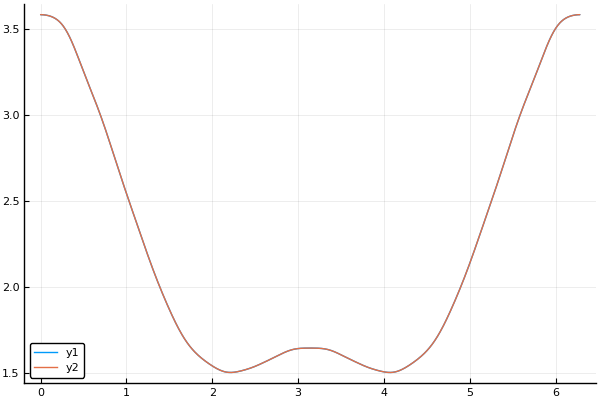

In [10]:
plot(Theta, [real.(z_spect_pred_num_CKMS.(Z)) real.(z_spect_pred_num.(Z))])

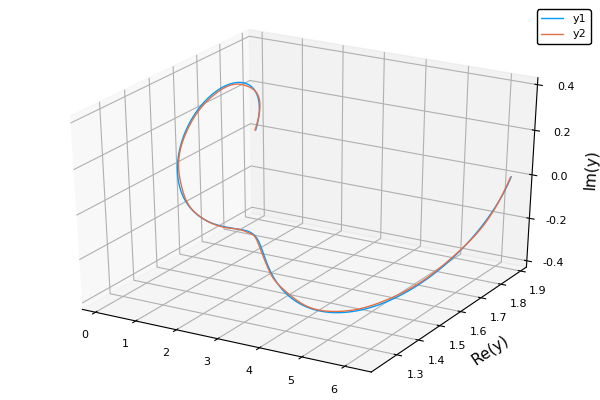

In [11]:
plot(Theta, [z_spect_pred_plus_ana.(Z) z_spect_pred_plus_num.(Z)])

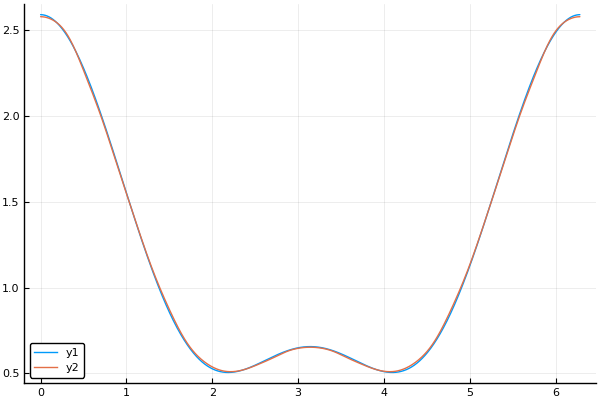

In [12]:
plot(Theta, [real.(z_crossspect_sigpred_ana.(Z)) real.(z_crossspect_sigpred_num.(Z))])

Here we verify that $S_X(z) = S_Y(z) + 1$

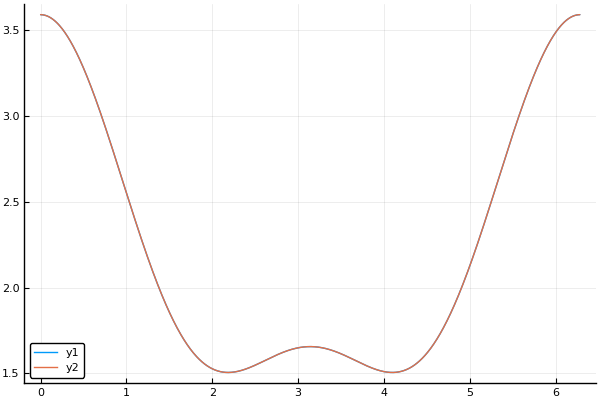

In [13]:
plot(Theta, [real.(z_spect_pred_ana.(Z)) real.(z_spect_sig_ana.(Z).+1)])

Here we verify the above formulae for $S_X(z)$ and $S_Y(z)$

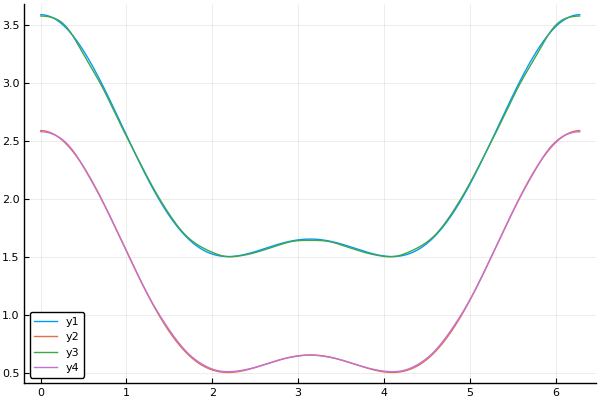

In [14]:
plot(Theta, [real.(z_spect_pred_ana.(Z)) real.(z_spect_sig_ana.(Z) 
             ) real.(z_spect_pred_num.(Z)) real.(z_spect_sig_num.(Z))])

In [15]:
S_sigpred_invS_plus_fft_num = fft(z_crossspect_sigpred_num.(Z)./z_spect_pred_plus_num.(Z))/Nex

1024-element Array{Complex{Float64},1}:
      0.7559948290786469 - 2.7401515843676616e-18im
     0.14498009896138364 + 0.000444794768392915im  
    0.037956707563376116 + 0.0002329023635917286im 
    -0.02228931227119451 - 0.0002051540537966819im 
   0.0013670637777979501 + 1.677723878349081e-5im  
    0.001012510628110558 + 1.5532936879896626e-5im 
  -0.0006263721050434268 - 1.1531415789822206e-5im 
   -0.000405950099381231 - 8.719415672547514e-6im  
   0.0006811066281167358 + 1.672022922952242e-5im  
   0.0006444995586672173 + 1.7800222814684735e-5im 
 -0.00036796081834513403 - 1.1292439703942628e-5im 
  0.00012254070273563957 + 4.137022511562451e-6im  
   0.0005023825003222994 + 1.8503843180513748e-5im 
                         ⋮                         
   -0.000583761636165895 + 2.1501214241106805e-5im 
  -0.0010081681341934205 + 3.403615430210978e-5im  
  -0.0007365580414697662 + 2.2604410190083386e-5im 
   -0.000968056869740019 + 2.673644651408e-5im     
  -0.0006339799857193242

In [16]:
rr = 1/r1 + 1/r1';
S_sigpred_invS_plus_fft_ana = 1/sqrt(0.21)/abs(r1)*[1.2041 + 0.484rr + 0.21*(1/r1^2 + 1/(r1')^2), 0.21, 0.484 + 0.21rr]

3-element Array{Complex{Float64},1}:
  0.7396186130432736 + 0.0im
  0.1452436988131014 + 0.0im
 0.30419406539225674 + 0.0im

In [17]:
ind = [1, Nex-1, Nex]
norm(S_sigpred_invS_plus_fft_num[ind] .- S_sigpred_invS_plus_fft_ana)

0.01683383658479725

In [18]:
Nexh = Int(floor(Nex/2))
S_sigpred_invS_plus_fft_plus_num = [S_sigpred_invS_plus_fft_num[1]; zeros(Nexh - 1); S_sigpred_invS_plus_fft_num[Nexh + 1:end]];

S_sigpred_invS_plus_fft_plus_ana = [S_sigpred_invS_plus_fft_ana[1]; zeros(Nex - 3); S_sigpred_invS_plus_fft_ana[2:3]];

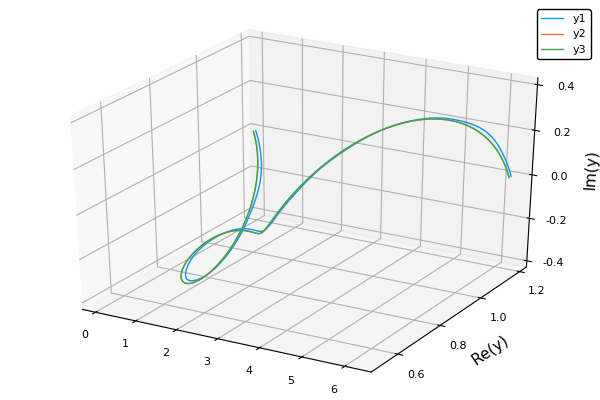

In [19]:
S_sigpred_invS_plus_plus_num = ifft(S_sigpred_invS_plus_fft_plus_num)*Nex
S_sigpred_invS_plus_plus_ana = ifft(S_sigpred_invS_plus_fft_plus_ana)*Nex
S_sigpred_invS_plus_plus_ana_con(z) = S_sigpred_invS_plus_fft_ana[1]+
                                      S_sigpred_invS_plus_fft_ana[2]*z^(-2) + 
                                      S_sigpred_invS_plus_fft_ana[3]*z^(-1)

plot(Theta, [S_sigpred_invS_plus_plus_num S_sigpred_invS_plus_plus_ana S_sigpred_invS_plus_plus_ana_con.(Z)])

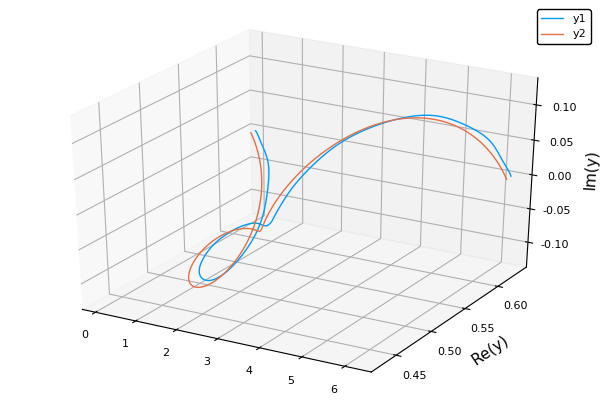

In [20]:
H_num = S_sigpred_invS_plus_plus_num./z_spect_pred_minus_num.(Z);

alp = S_sigpred_invS_plus_fft_ana[1]
gam = S_sigpred_invS_plus_fft_ana[2]
bet = S_sigpred_invS_plus_fft_ana[3]

H_ana(z) = abs(r1)/sqrt(0.21)*(alp + bet/z + gam/z^2)/(r1 - 1/z)/(r1' - 1/z);

plot(Theta, [H_num H_ana.(Z)])

In [21]:
h_num_raw = fft(H_num)/Nex
h_num = [h_num_raw[1]; reverse(h_num_raw)[1:Nexh]]

513-element Array{Complex{Float64},1}:
      0.5228843834789102 - 3.0620241043242957e-19im
     0.10103722693781024 - 0.0003099793025167861im 
    0.025777701912228872 - 0.00015817198299659848im
   -0.015267515070805914 + 0.0001405244168177253im 
  0.00031661427058551835 - 3.8856367245919265e-6im 
   0.0010823781473840205 - 1.660477527517278e-5im  
  -0.0007429740243807523 + 1.36780395026991e-5im   
  -0.0005976630499277865 + 1.2837224507111279e-5im 
   0.0002703245405241131 - 6.63609499208783e-6im   
  -0.0003797057170097376 + 1.048696818467529e-5im  
 -0.00025948882181567583 + 7.963516026999514e-6im  
 -0.00020753188991546315 + 7.006358550916778e-6im  
   0.0002501416550159811 - 9.213262711901063e-6im  
                         ⋮                         
  -2.4247770427461085e-9 + 7.182312454618328e-8im  
  -2.2044672915961323e-9 + 7.18319165940566e-8im   
  -1.9841862562860834e-9 + 7.184219993492518e-8im  
  -1.7639234542140333e-9 + 7.18542756242665e-8im   
  -1.5436668752185078e-9 

In [22]:
h_ana = 1/(sqrt(r1)*abs(r1))*[alp, bet + alp*rr, gam + alp*(1/r1^2 + 1/(r1')^2 + 1/abs(r1)^2) + bet*rr]
append!(h_ana,zeros(Nex -3))
h_ana

1024-element Array{Complex{Float64},1}:
  0.07627708629393357 - 0.10769873483142958im 
  0.01532355290509775 - 0.02163595046934505im 
 0.004092595402427334 - 0.005778502672740452im
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                      ⋮                       
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.0 + 0.0im                 
                  0.

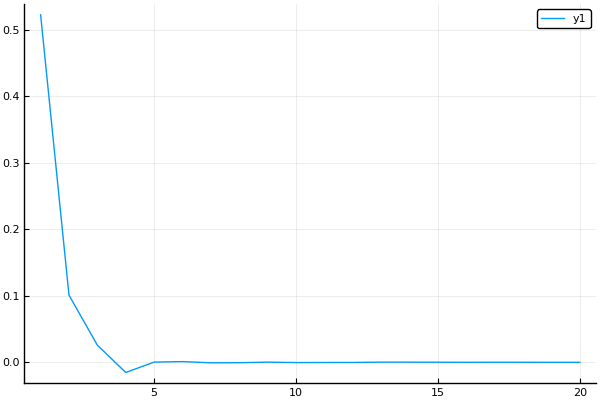

In [23]:
plot(real.(h_num[1:20]) )

Now to verify the preformance.

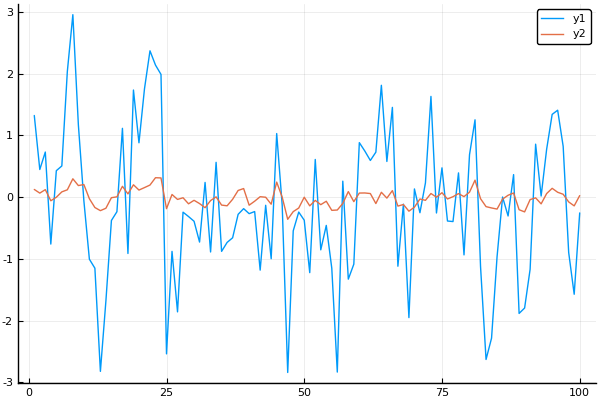

In [24]:
sig_hat = conv(real.(h_ana),pred)[1:steps]

time = 1:100
plot(time,[sig[time] sig_hat[time]])

In [26]:
error = sig .-sig_hat
lags = -30:3
C = crosscov(error,pred,lags)

34-element Array{Float64,1}:
 -0.0023272437495789767 
 -0.00042344732566057574
 -0.000596375377228856  
  0.0004870307071174178 
 -0.0005478595851374164 
 -0.0013394779069507165 
 -0.0002624893815576845 
 -0.0019043223666215451 
 -0.000807433502030875  
  5.484159411116195e-5  
  0.0006580676941387371 
 -0.00035783543871656143
  0.0018859692056748536 
  ⋮                     
 -0.0004120094441395641 
 -0.001299639376495365  
  0.0004586263355075231 
  4.4749855839678276e-5 
  0.0024324205786110556 
 -0.003548368740925502  
  0.17917092602512358   
  0.412339732519789     
  1.02831988921618      
  0.4466785011812663    
  0.19472194630820522   
  0.0013834000866814692 

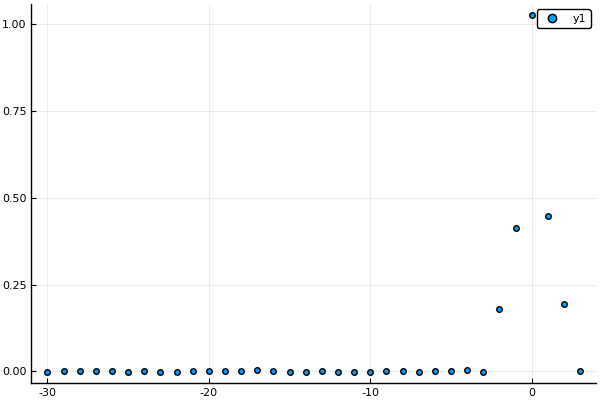

In [30]:
scatter(lags, C)